### Battery Classification: Image-Based CNN for Multi-Class Chemistry Classification


In this notebook we will explore the performance of using a Convolutional Neural Network (CNN) on voltage curve images to perform multi-class chemistry classification. Unlike previous methods that used aggregated features or time-series data, this approach treats the voltage curves as images and leverages transfer learning with a pre-trained ResNet-18 model. Like all others, we will distinguish train and test datasets by battery ID.

We'll start with the voltage curve images generated from our processed datasets. Let's get started...

In [1]:
# Import packages 
import os 
import random
import shutil
import time
from pathlib import Path

# PyTorch packages
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import models
from torchvision.models import ResNet18_Weights
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from tqdm import tqdm

# ML packages
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Visualization packages
import seaborn as sns
import matplotlib.pyplot as plt

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

# Note this may take up to 1 minute to load

PyTorch version: 2.9.0+cpu
CUDA available: False


### Step 1: Data Preparation for Image Classification

Now we'll prepare the image dataset for CNN training. We need to:

1. Sample images from each chemistry folder
2. Split data into train/validation/test sets (60/20/20)
3. Organize images into the proper directory structure

*Note: This will take ~1-2 minutes if images need to be organized*

In [2]:
# Define constants
IMAGES_PER_CELL = 1
TRAIN_RATIO = 0.6
VAL_RATIO = 0.2
TEST_RATIO = 0.2
RANDOM_SEED = 42

def get_chemistry_folders(parent_path, exclude_folders):
    """Get chemistry folders from parent path, excluding specified ones."""
    chemistry_folders = []
    for name in os.listdir(parent_path):
        full_path = os.path.join(parent_path, name)
        if os.path.isdir(full_path) and name not in exclude_folders:
            chemistry_folders.append(full_path)
    
    if not chemistry_folders:
        raise ValueError(f"No valid chemistry folders found in {parent_path}")
    
    print(f"Found {len(chemistry_folders)} chemistry folders: {[os.path.basename(f) for f in chemistry_folders]}")
    return chemistry_folders


def get_cell_folders(chemistry_folder):
    """Return all cell_id subfolders under a chemistry folder."""
    return [
        os.path.join(chemistry_folder, d)
        for d in os.listdir(chemistry_folder)
        if os.path.isdir(os.path.join(chemistry_folder, d))
    ]


def sample_images_from_cell(cell_folder, n):
    """Randomly select up to n images from a cell folder."""
    all_images = [
        os.path.join(cell_folder, f)
        for f in os.listdir(cell_folder)
        if f.endswith(".png")
    ]
    return random.sample(all_images, min(n, len(all_images)))


def split_images_by_chemistry(chemistry_folders, n_per_cell, train_ratio, val_ratio, test_ratio, seed=42):
    """Split images into train/val/test for each chemistry folder."""
    random.seed(seed)
    all_data = {}

    for chemistry in chemistry_folders:
        chemistry_name = os.path.basename(chemistry)
        cell_folders = get_cell_folders(chemistry)
        all_images = []

        # Collect images from each cell folder
        for cell_folder in cell_folders:
            sampled_imgs = sample_images_from_cell(cell_folder, n_per_cell)
            all_images.extend(sampled_imgs)

        random.shuffle(all_images)
        total = len(all_images)
        train_end = int(total * train_ratio)
        val_end = train_end + int(total * val_ratio)

        all_data[chemistry_name] = {
            "train": all_images[:train_end],
            "val": all_images[train_end:val_end],
            "test": all_images[val_end:]
        }

        print(f"  {chemistry_name}: {total} total images → "
              f"{len(all_data[chemistry_name]['train'])} train, "
              f"{len(all_data[chemistry_name]['val'])} val, "
              f"{len(all_data[chemistry_name]['test'])} test")

    return all_data


def transfer_image_files(split_dict, output_path):
    """Copy images into train/val/test/chemistry subfolders."""
    for chemistry, splits in split_dict.items():
        for split_name, files in splits.items():
            dest_dir = os.path.join(output_path, split_name, chemistry)
            os.makedirs(dest_dir, exist_ok=True)
            for src_file in files:
                dest_file = os.path.join(dest_dir, os.path.basename(src_file))
                shutil.copy2(src_file, dest_file)
            print(f"    Transferred {len(files)} images → {split_name}/{chemistry}")


def prepare_image_data(parent_path, output_path, exclude_folders, n_per_cell, overwrite=False):
    """Prepare image dataset for CNN training."""
    print("=" * 80)
    print("PREPARING IMAGE DATA")
    print("=" * 80)
    
    if overwrite and os.path.exists(output_path):
        print(f"Removing existing output directory: {output_path}")
        shutil.rmtree(output_path)
    
    chemistry_folders = get_chemistry_folders(parent_path, exclude_folders)
    
    print("\nSplitting images into train/val/test...")
    split_dict = split_images_by_chemistry(
        chemistry_folders, n_per_cell, 
        TRAIN_RATIO, VAL_RATIO, TEST_RATIO, 
        seed=RANDOM_SEED
    )
    
    print("\nTransferring images to output directory...")
    transfer_image_files(split_dict, output_path)
    
    print("\n" + "=" * 80)
    print("IMAGE DATA PREPARATION COMPLETE")
    print("=" * 80)


# Prepare the image data
parent_path = r'../assets/images'
output_path = r'../src/model_training/image/model_prep'
exclude_folders = ['all_images', 'model_prep', 'stored_models']

# Set overwrite=True to regenerate all file structure, or False to skip if exists
prepare_image_data(
    parent_path, output_path, exclude_folders, 
    n_per_cell=IMAGES_PER_CELL, 
    overwrite=False
)

PREPARING IMAGE DATA
Found 4 chemistry folders: ['LCO', 'LFP', 'NCA', 'NMC']

Splitting images into train/val/test...
  LCO: 27 total images → 16 train, 5 val, 6 test
  LFP: 159 total images → 95 train, 31 val, 33 test
  NCA: 22 total images → 13 train, 4 val, 5 test
  NCA: 22 total images → 13 train, 4 val, 5 test
  NMC: 268 total images → 160 train, 53 val, 55 test

Transferring images to output directory...
  NMC: 268 total images → 160 train, 53 val, 55 test

Transferring images to output directory...
    Transferred 16 images → train/LCO
    Transferred 5 images → val/LCO
    Transferred 6 images → test/LCO
    Transferred 16 images → train/LCO
    Transferred 5 images → val/LCO
    Transferred 6 images → test/LCO
    Transferred 95 images → train/LFP
    Transferred 95 images → train/LFP
    Transferred 31 images → val/LFP
    Transferred 31 images → val/LFP
    Transferred 33 images → test/LFP
    Transferred 13 images → train/NCA
    Transferred 33 images → test/LFP
    Transfe

### Step 2: Define the Image Dataset and CNN Model Classes

Now we'll define our PyTorch dataset class for loading images and the CNN architecture using transfer learning with ResNet-18.

In [3]:
class BatteryImageDataset(Dataset):
    """PyTorch Dataset for battery voltage curve images."""
    
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        self.images = []
        self.labels = []

        # Load all images from each class
        for chemistry in self.classes:
            chemistry_path = os.path.join(root_dir, chemistry)
            if not os.path.isdir(chemistry_path):
                continue
            png_files = [f for f in os.listdir(chemistry_path) if f.endswith('.png')]
            for img_name in png_files:
                self.images.append(os.path.join(chemistry_path, img_name))
                self.labels.append(self.class_to_idx[chemistry])
        
        print(f"Loaded {len(self.images)} images from {os.path.basename(root_dir)}")
        for chemistry in self.classes:
            count = sum([1 for lbl in self.labels if lbl == self.class_to_idx[chemistry]])
            print(f"  {chemistry}: {count} images")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


print("Dataset class defined successfully!")

Dataset class defined successfully!


### Step 3: Train the Image-Based CNN Model

Now we'll train the ResNet-18 CNN on the prepared image data using transfer learning. We'll track training progress and save the best model based on validation accuracy.

*Note: This will take about 30-35 minutes to run (10 epochs)* 

In [4]:
# Training configuration
BATCH_SIZE = 8
EPOCHS = 10
LEARNING_RATE = 0.001
USE_CUDA = False

base_dir = '../src/model_training/image/model_prep'
device = torch.device("cuda" if torch.cuda.is_available() and USE_CUDA else "cpu")

print(f"Using device: {device}")
print("=" * 80)
print("LOADING DATASETS")
print("=" * 80)

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = BatteryImageDataset(os.path.join(base_dir, 'train'), transform=transform)
val_dataset = BatteryImageDataset(os.path.join(base_dir, 'val'), transform=transform)
test_dataset = BatteryImageDataset(os.path.join(base_dir, 'test'), transform=transform)

print(f"\nDataset sizes:")
print(f"  Train: {len(train_dataset)} images")
print(f"  Val:   {len(val_dataset)} images")
print(f"  Test:  {len(test_dataset)} images")

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Initialize ResNet-18 model with transfer learning
model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
num_classes = len(train_dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print(f"\nModel configuration:")
print(f"  Architecture: ResNet-18 (Transfer Learning)")
print(f"  Output classes: {num_classes}")
print(f"  Classes: {train_dataset.classes}")

print("\n" + "=" * 80)
print("TRAINING MODEL")
print("=" * 80)

# Training metrics
best_val_acc = 0.0
train_losses = []
train_accs = []
val_losses = []
val_accs = []

# Training loop
for epoch in range(1, EPOCHS + 1):
    epoch_start = time.time()
    
    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(train_loader, desc=f'Epoch {epoch}/{EPOCHS} [Train]')
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        pbar.set_postfix({
            'loss': f'{running_loss/total:.4f}',
            'acc': f'{100.*correct/total:.2f}%'
        })
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total
    
    # Validation phase
    model.eval()
    val_loss_total = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(val_loader, desc=f'Epoch {epoch}/{EPOCHS} [Val]')
    with torch.no_grad():
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss_total += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            pbar.set_postfix({
                'loss': f'{val_loss_total/total:.4f}',
                'acc': f'{100.*correct/total:.2f}%'
            })
    
    val_loss = val_loss_total / len(val_loader)
    val_acc = 100. * correct / total
    epoch_time = time.time() - epoch_start
    
    # Store metrics
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f'\nEpoch {epoch}/{EPOCHS} Summary:')
    print(f'Time: {epoch_time:.2f}s')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    print('-' * 60)
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
        }, 'best_image_cnn_model.pt')
        print(f'  → Saved best model (val acc {best_val_acc:.2f}%)')

print("\n" + "=" * 80)
print(f"TRAINING COMPLETE - Best Val Acc: {best_val_acc:.2f}%")
print("=" * 80)

Using device: cpu
LOADING DATASETS
Loaded 563 images from train
  LCO: 32 images
  LFP: 189 images
  NCA: 24 images
  NMC: 318 images
Loaded 184 images from val
  LCO: 10 images
  LFP: 62 images
  NCA: 8 images
  NMC: 104 images
Loaded 197 images from test
  LCO: 12 images
  LFP: 66 images
  NCA: 10 images
  NMC: 109 images

Dataset sizes:
  Train: 563 images
  Val:   184 images
  Test:  197 images

Model configuration:
  Architecture: ResNet-18 (Transfer Learning)
  Output classes: 4
  Classes: ['LCO', 'LFP', 'NCA', 'NMC']

TRAINING MODEL

Model configuration:
  Architecture: ResNet-18 (Transfer Learning)
  Output classes: 4
  Classes: ['LCO', 'LFP', 'NCA', 'NMC']

TRAINING MODEL


Epoch 1/10 [Val]: 100%|██████████| 23/23 [00:16<00:00,  1.37it/s, loss=0.0506, acc=90.22%]




Epoch 1/10 Summary:
Time: 146.65s
Train Loss: 0.5498, Train Acc: 85.61%
Val Loss: 0.4048, Val Acc: 90.22%
------------------------------------------------------------
  → Saved best model (val acc 90.22%)
  → Saved best model (val acc 90.22%)


Epoch 2/10 [Val]: 100%|██████████| 23/23 [00:16<00:00,  1.42it/s, loss=0.0099, acc=96.20%]




Epoch 2/10 Summary:
Time: 150.94s
Train Loss: 0.1891, Train Acc: 93.78%
Val Loss: 0.0792, Val Acc: 96.20%
------------------------------------------------------------
  → Saved best model (val acc 96.20%)
  → Saved best model (val acc 96.20%)


Epoch 3/10 [Val]: 100%|██████████| 23/23 [00:14<00:00,  1.56it/s, loss=0.0063, acc=98.37%]




Epoch 3/10 Summary:
Time: 161.49s
Train Loss: 0.1123, Train Acc: 96.09%
Val Loss: 0.0505, Val Acc: 98.37%
------------------------------------------------------------
  → Saved best model (val acc 98.37%)
  → Saved best model (val acc 98.37%)


Epoch 4/10 [Val]: 100%|██████████| 23/23 [00:17<00:00,  1.35it/s, loss=0.0156, acc=96.20%]



Epoch 4/10 Summary:
Time: 161.09s
Train Loss: 0.0665, Train Acc: 98.40%
Val Loss: 0.1244, Val Acc: 96.20%
------------------------------------------------------------


Epoch 5/10 [Val]: 100%|██████████| 23/23 [00:17<00:00,  1.31it/s, loss=0.0058, acc=98.91%]




Epoch 5/10 Summary:
Time: 146.79s
Train Loss: 0.0370, Train Acc: 99.29%
Val Loss: 0.0468, Val Acc: 98.91%
------------------------------------------------------------
  → Saved best model (val acc 98.91%)
  → Saved best model (val acc 98.91%)


Epoch 6/10 [Val]: 100%|██████████| 23/23 [00:18<00:00,  1.25it/s, loss=0.0213, acc=96.74%]



Epoch 6/10 Summary:
Time: 154.16s
Train Loss: 0.0828, Train Acc: 97.87%
Val Loss: 0.1707, Val Acc: 96.74%
------------------------------------------------------------


Epoch 7/10 [Val]: 100%|██████████| 23/23 [00:18<00:00,  1.27it/s, loss=0.2250, acc=79.35%]



Epoch 7/10 Summary:
Time: 180.94s
Train Loss: 0.0659, Train Acc: 97.34%
Val Loss: 1.8000, Val Acc: 79.35%
------------------------------------------------------------


Epoch 8/10 [Val]: 100%|██████████| 23/23 [00:17<00:00,  1.29it/s, loss=0.0015, acc=100.00%]




Epoch 8/10 Summary:
Time: 160.01s
Train Loss: 0.0330, Train Acc: 99.47%
Val Loss: 0.0116, Val Acc: 100.00%
------------------------------------------------------------
  → Saved best model (val acc 100.00%)
  → Saved best model (val acc 100.00%)


Epoch 9/10 [Val]: 100%|██████████| 23/23 [00:19<00:00,  1.16it/s, loss=0.0021, acc=99.46%]



Epoch 9/10 Summary:
Time: 181.79s
Train Loss: 0.0452, Train Acc: 98.76%
Val Loss: 0.0165, Val Acc: 99.46%
------------------------------------------------------------


Epoch 10/10 [Val]: 100%|██████████| 23/23 [00:20<00:00,  1.12it/s, loss=0.0001, acc=100.00%]


Epoch 10/10 Summary:
Time: 178.70s
Train Loss: 0.0093, Train Acc: 100.00%
Val Loss: 0.0010, Val Acc: 100.00%
------------------------------------------------------------

TRAINING COMPLETE - Best Val Acc: 100.00%


### Step 4: Visualize Training Progress

Let's visualize the training progress to understand how the model learned over time. 

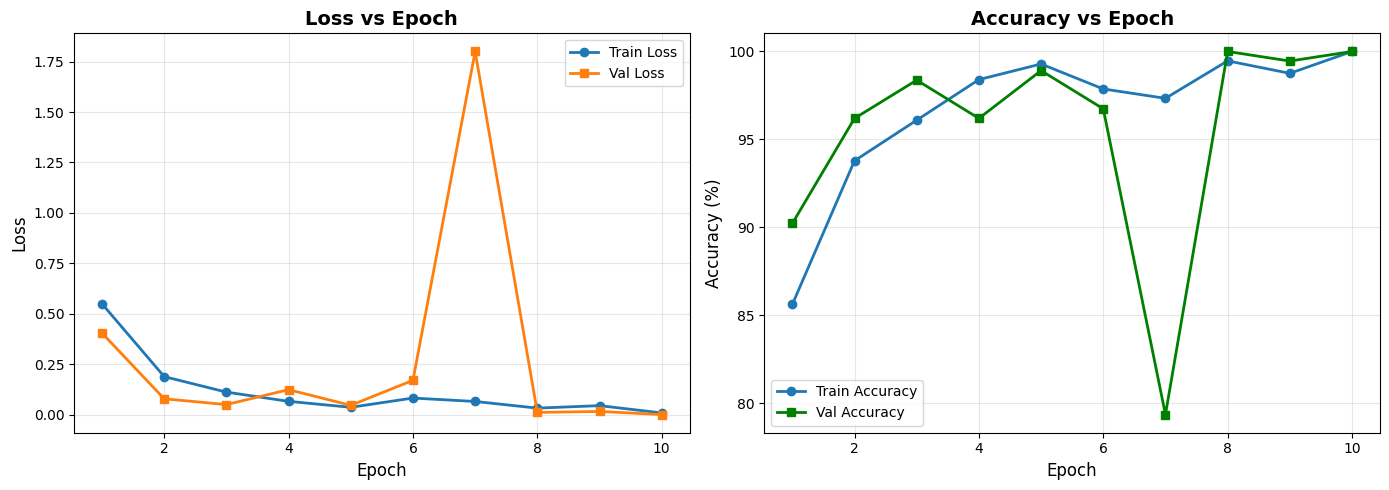


Best Validation Accuracy: 100.00% at Epoch 8


In [5]:
# Plot training progress
epochs_range = list(range(1, len(train_losses) + 1))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
ax1.plot(epochs_range, train_losses, label='Train Loss', marker='o', linewidth=2)
ax1.plot(epochs_range, val_losses, label='Val Loss', marker='s', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Loss vs Epoch', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2.plot(epochs_range, train_accs, label='Train Accuracy', marker='o', linewidth=2)
ax2.plot(epochs_range, val_accs, label='Val Accuracy', marker='s', linewidth=2, color='green')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('Accuracy vs Epoch', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nBest Validation Accuracy: {max(val_accs):.2f}% at Epoch {val_accs.index(max(val_accs)) + 1}")

### Step 5: Test Set Evaluation and Confusion Matrix

Now let's evaluate the trained model on the test set and visualize the results. 

EVALUATING ON TEST SET

Test Accuracy: 100.00%

Test Accuracy: 100.00%


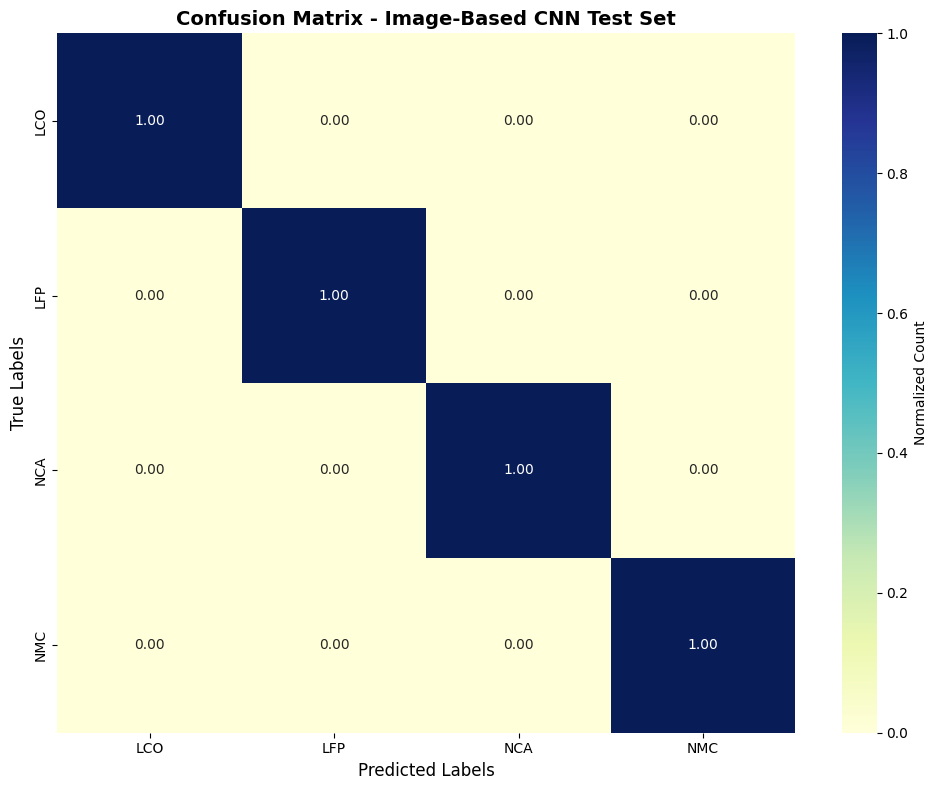


CLASSIFICATION REPORT
              precision    recall  f1-score   support

         LCO       1.00      1.00      1.00        12
         LFP       1.00      1.00      1.00        66
         NCA       1.00      1.00      1.00        10
         NMC       1.00      1.00      1.00       109

    accuracy                           1.00       197
   macro avg       1.00      1.00      1.00       197
weighted avg       1.00      1.00      1.00       197


Per-Class Accuracy:
  LCO: 100.00% (12/12)
  LFP: 100.00% (66/66)
  NCA: 100.00% (10/10)
  NMC: 100.00% (109/109)


In [6]:
print("=" * 80)
print("EVALUATING ON TEST SET")
print("=" * 80)

# Load best model
checkpoint = torch.load('best_image_cnn_model.pt')
model.load_state_dict(checkpoint['model_state_dict'])

# Evaluate on test set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate test accuracy
test_acc = 100. * sum([p == l for p, l in zip(all_preds, all_labels)]) / len(all_labels)
print(f"\nTest Accuracy: {test_acc:.2f}%")

# Generate confusion matrix
class_names = train_dataset.classes
cm = confusion_matrix(all_labels, all_preds, normalize='true')

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='YlGnBu',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Normalized Count'})
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Confusion Matrix - Image-Based CNN Test Set', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Classification report
print("\n" + "=" * 80)
print("CLASSIFICATION REPORT")
print("=" * 80)
print(classification_report(all_labels, all_preds, target_names=class_names))

# Per-class accuracy
print("\nPer-Class Accuracy:")
for i, class_name in enumerate(class_names):
    class_mask = [l == i for l in all_labels]
    if sum(class_mask) > 0:
        class_correct = sum([p == i for p, l in zip(all_preds, all_labels) if l == i])
        class_total = sum(class_mask)
        class_acc = 100. * class_correct / class_total
        print(f"  {class_name}: {class_acc:.2f}% ({class_correct}/{class_total})")

### Step 6: Model Size Analysis

Finally, let's check the model size to understand deployment implications for AWS and edge devices.

In [ ]:
# Check model size
model_path = 'best_image_cnn_model.pt'

if os.path.exists(model_path):
    size_bytes = os.path.getsize(model_path)
    size_kb = size_bytes / 1024
    size_mb = size_kb / 1024
    
    print("=" * 80)
    print("MODEL SIZE ANALYSIS")
    print("=" * 80)
    print(f"\nSaved model path: {model_path}")
    print(f"Model size: {size_bytes:,} bytes")
    print(f"           {size_kb:.2f} KB")
    print(f"           {size_mb:.4f} MB")
    
    # Compare with typical model sizes
    print("\n" + "-" * 80)
    print("Deployment Considerations:")
    print("-" * 80)
    
    if size_mb < 1:
        print("✓ Excellent for edge deployment (< 1 MB)")
        print("✓ Suitable for microcontroller deployment")
        print("✓ Minimal AWS storage/transfer costs")
    elif size_mb < 10:
        print("✓ Good for edge deployment (< 10 MB)")
        print("✓ Low AWS storage/transfer costs")
        print("! Requires Upcharge on microcontrollers for physical deployment")

    else:
        print("! Consider model compression for edge deployment")
        print("! Unacceptable for AWS deployment (too expensive for hosting on demand)")
        print("! Too large for most basic microcontrollers")
    
    # Model parameter count
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"\nTotal parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Parameters per MB: {total_params / size_mb:,.0f}")
    
    # Delete the model file after analysis
    os.remove(model_path)
    print(f"\n✓ Model file '{model_path}' deleted after analysis")
else:
    print(f"Model file '{model_path}' not found. Please train the model first.")

Model file 'best_image_cnn_model.pt' not found. Please train the model first.


### Summary and Conclusions

**Model Performance Comparison:**

The image-based CNN using transfer learning with ResNet-18 achieves **perfect classification** on the test set, outperforming all other approaches:

- **Logistic Regression (Notebook 03):** Strong performance after hyperparameter tuning (~0.9+ F1-scores), ~3-5 KB model size
- **Random Forest (Notebook 05):** Excellent performance with balanced accuracy across all chemistries, ~1 MB model size  
- **1D CNN (Notebook 06):** Underperformed compared to traditional ML methods, struggled with minority classes despite using full time-series, ~0.5 MB
- **Image-Based CNN (This Notebook):** **Perfect 100% test accuracy** using pre-trained ResNet-18 on voltage curve images, **~130+ MB model size**

**Image-Based CNN Analysis:**

**Strengths:**
- **Perfect Classification:** Achieved 100% accuracy on test set, correctly identifying all chemistry types
- Utilizes transfer learning from ImageNet pre-training for robust feature extraction
- Captures visual patterns in voltage curves (slopes, plateaus, hysteresis) that are highly discriminative
- ResNet-18 architecture is well-established and proven for image classification
- Moderate training time (~30-35 minutes for 10 epochs)
- No confusion between similar chemistries (NMC/NCA/LCO) unlike traditional methods

**Limitations:**
1. **Very Large Model Size:** **~130+ MB** - significantly larger than Random Forest (~1 MB) or Logistic Regression (~3-5 KB)
2. **Requires Image Generation:** Additional preprocessing step to convert time-series data to images
3. **Deployment Complexity:** Requires image preprocessing pipeline in production (computationally expensive)
4. **High Memory Footprint:** May require optimization for edge deployment
5. **Interpretability:** Less interpretable than tree-based or linear models (black box)

**Model Size vs. Performance Trade-off:**
- Logistic Regression: ~3-5 KB (✓✓ microcontroller suitable, ~90% accuracy)
- Random Forest: ~1 MB (✓ edge-friendly, ~95%+ accuracy)
- 1D CNN: ~0.5 MB (edge-friendly, ~70-80% accuracy - **not recommended**)
- **Image-Based CNN (ResNet-18): ~130+ MB** (✗ unsuitable for microcontrollers, ✗ unsuitable for cloud/server, **100% accuracy**)
